# Ames Housing Data EDA

This project aims to predict housing prices in Ames, Iowa based on the famous Ames Iowa Housing Dataset from the Ames City Assessor's Office, made available by Dean De Cock of Truman University in 2011. Professor De Cock's original paper can be found [here.](http://jse.amstat.org/v19n3/decock.pdf)

Presentation Slides for this project can be found [here.](https://www.beautiful.ai/player/-N4J5UYshyuRtwl5G4I7)

This notebook includes python code for data extraction, cleaning and transformation. Model Fitting and Analysis code can be found in the Ames_Models notebook.

# Sections and steps

- <a href="#IMP">Reading in Data</a><br>
    - Import Packages needed
    - Import helper module
    - Read in training data
    - Read in test data
- <a href="#EDA">Exploratory Data Analysis</a><br>
    - Dependent Variable Analysis
    - Independent Variable Analysis
        - Missing Values
        - Handling Outliers and Anomalies
        - Categorical Features
            - box plot, bar plot to see distributions
            - ANOVA tests for select features
            - Flag for feature engineering
        - Quantitative Features
            - correlation matrix, and histogram
- <a href="#FEN">Feature Engineering</a><br>
    - Dropped Features
        - columns with no meaningful difference between categories
        - low correlation
        - Multicollinearity
    - Feature Engineering
        - Land and Exterior
        - House Quality
        - Location
        - Garage
        - Basement
        - Sale Info
- <a href="#PRE">Preparing Data for Models</a><br>
    - Linear Models
        -dummify categorical variables
    - Non Linear Models
        -label encode categorical variables
    - All Models
        -split train and validate datasets
        -standardize the numerical variables
- <a href="#EXP">Exporting Cleaned Datasets</a><br>

<p><a name="IMP"></a></p>

## Importing Packages, Reading in Data

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

### Importing helper module

In [64]:
#importing helper functions from helper module
from helper_module import *

### Reading in train data

In [65]:
train = pd.read_csv('./data/raw/train.csv')
train.head()
#train.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Train Data - Shape: {train.shape}")

Read in Ames Housing Train Data - Shape: (1460, 81)


### Reading in test data

In [66]:
test = pd.read_csv('./data/raw/test.csv')
test.head()
#test.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Test Data - Shape: {test.shape}")

Read in Ames Housing Test Data - Shape: (1459, 80)


<p><a name="EDA"></a></p>

## Exploratory Data Analysis

### Train Dataset

In [83]:
print('The raw number of features is ', train.shape[1])
print('The raw number of observations is ', train.shape[0])
print('The datattypes are:', train.dtypes.unique())

The raw number of features is  81
The raw number of observations is  1460
The datattypes are: [dtype('int64') dtype('O') dtype('float64')]


In [84]:
#selecting just categorical variables in the dataframe and creating a list
cat_var = train.select_dtypes('O').columns.tolist()

#selecting just continuous variables in the dataframe and creating a list
num_var = train.select_dtypes('number').columns.tolist()

print('The number of categorical features is' , len(cat_var))
print('The number of numerical features is', len(num_var))

#Sanity check here
print('The combined numerical and categorical features are', len(cat_var) + len(num_var))

The number of categorical features is 43
The number of numerical features is 38
The combined numerical and categorical features are 81


In [76]:
'''#Creating iterators for variable lists
cat_iter = iter(cat_var)
num_iter = iter(num_var)
'''

Looking at our independent variables and data description, we will group our variables into four 'buckets' -
1. Building Features and Quality
2. Lot Features and Quality
3. Location
4. Sale Information

### Dependent Variable Analysis - Sale Price

In [7]:
#descriptive summary of Sale Price
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

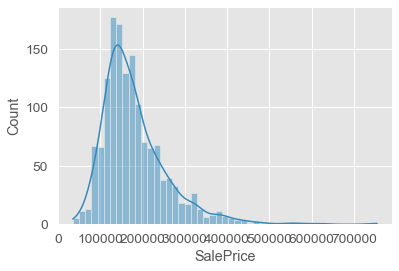

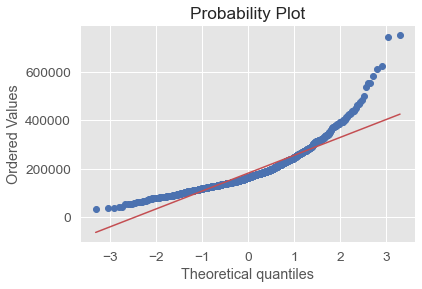

In [86]:
#plotting a histogram using seaborn
#histogram
sns.histplot(train['SalePrice'], kde = True);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
#TODO - clean up this diagram

Noticing that the dependent variable looks right skewed (aka not normally distributed)

In [12]:
#checking skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


To ensure that the residuals of a linear model taken will be normal, we will take the log of the Sale Price instead of the Sale Price.

In [16]:
#changing sale price to log sale price
train['log_SalePrice'] = np.log(train['SalePrice'])

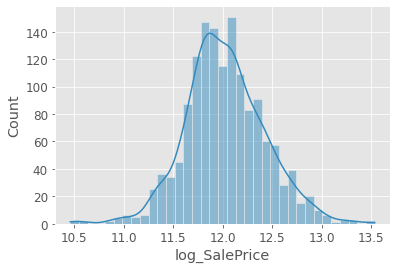

In [17]:
#plotting a histogram using seaborn
#histogram
sns.histplot(train['log_SalePrice'], kde = True);
#TODO - clean up this diagram

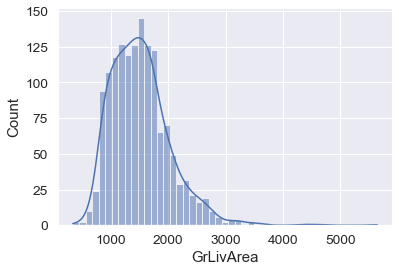

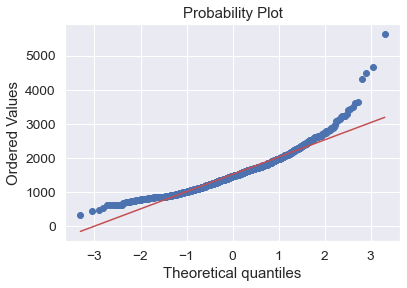

In [30]:
#histogram and normal probability plot
sns.histplot(train['GrLivArea'], kde = True);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

### Independent Variables Analysis

#### Missing Values

In [22]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing_data.head(25)

,Total,Percent Missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479


#### Handling Outliers and Anomalies

#### Categorical Features - box plot, bar plot, ANOVA

#### Quantitative Features - correlation matrix, histogram

### Summary of obs dropped, and vars flagged for feature engineering
- 4 observations dropped - outliers in gr liv area

#### Variables flagged for feature engineering

#### Looking into Multicollinearity

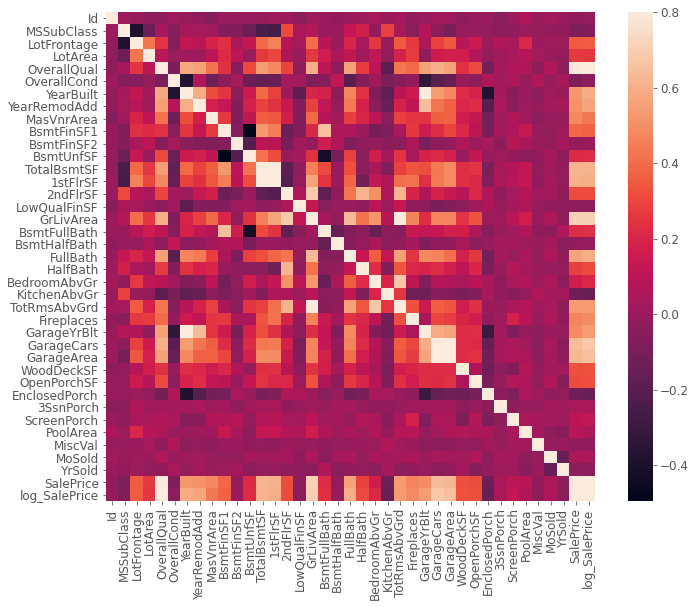

In [18]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

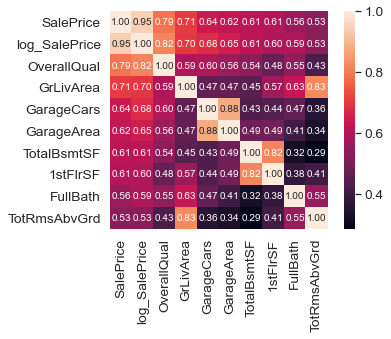

In [19]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<p><a name="FEN"></a></p>

## Feature Engineering

### Feature Engineering

Previously modified features:-

Sale Price -> Log of Sale Price

#### Land and Exterior

#### House Quality

#### Location

#### Garage

#### Basement

#### Sale Info

### Dropped Features

#### Columns with no meaningful difference between categories

#### Low correlation

#### Multicollinearity

#### Administrative Columns

<p><a name="PRE"></a></p>

## Preprocessing Data for Models

### Linear Models
#### Dummification of Categorical Variables

#### Testing Assumptions for Linear Models

### Non Linear Models
#### Label Encoding of Categorical Variables

### All Models
#### Standardization of numerical variables
#### Split train and validate datasets

<p><a name="EXP"></a></p>

## Exporting Cleaned Datasets